In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import h5py
import os
from scipy.stats import norm, halfnorm
import stan
import arviz as az

In [2]:
from general_model import temporally_augment, model_sample

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
project_dir = '/data/florican/jamiesonball/Intern_Project'

data_dir = os.path.join(project_dir, 'data')
data_filepath = os.path.join(data_dir, 'BGD_daily_inc_fatalities.h5')

data = pd.read_hdf(data_filepath,
                   key='event_data')

In [5]:
data = temporally_augment(data)

In [6]:
week_data = data.groupby(['WEEK', 'EVENT_TYPE'], as_index=False)[['FATALITIES', 'RAW_COUNTS']].sum()

In [7]:
week_data['FATALITY_FLAG'] = week_data['FATALITIES'].gt(0).astype(int)

In [8]:
week_data.loc[week_data['RAW_COUNTS'] > 0].loc[week_data['EVENT_TYPE']== 'Protests']['FATALITY_FLAG'].sum()

15

In [9]:
event_colours = {'Battles': (0.75, 0.3125, 0.4375),
                 'Explosions/Remote violence': (0.8125, 0.5, 0.1875),
                 'Riots': (0.75, 0.6875, 0.0),
                 'Violence against civilians': (0.3125, 0.5625, 0.0625),
                 'Protests': (0.1875, 0.375, 0.6875),
                 'Strategic developments': (0.5, 0.0625, 0.4375)}

In [10]:
event_colours.values()

dict_values([(0.75, 0.3125, 0.4375), (0.8125, 0.5, 0.1875), (0.75, 0.6875, 0.0), (0.3125, 0.5625, 0.0625), (0.1875, 0.375, 0.6875), (0.5, 0.0625, 0.4375)])

In [11]:
grouped_data = week_data.loc[week_data['RAW_COUNTS'] > 0].groupby('EVENT_TYPE', as_index=False)

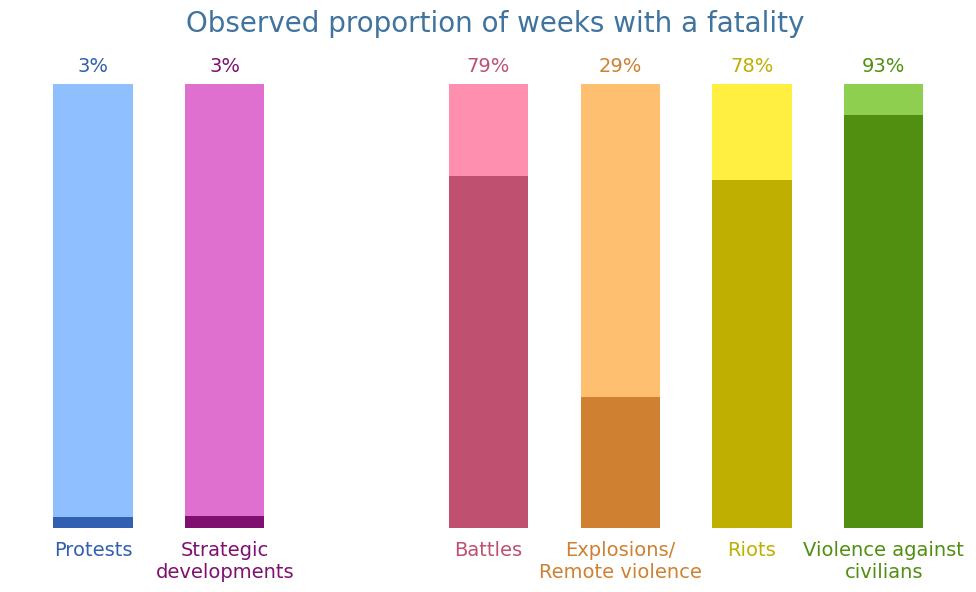

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

bar_width = 0.6
bar_spacing = 0.2

x_positions = [0, 1, 5, 2, 6, 3]
x_positions = [3, 4, 0, 5, 1, 6]

event_types_dict = {'Battles':'Battles',
                    'Explosions/Remote violence':'Explosions/\nRemote violence',
                    'Protests':'Protests',
                    'Riots':'Riots',
                    'Strategic developments':'Strategic\ndevelopments',
                    'Violence against civilians':'Violence against\ncivilians'}


for idx, (event_type, df) in enumerate(grouped_data):
    zero = len(df.loc[df['FATALITY_FLAG'] == 0])
    one = len(df.loc[df['FATALITY_FLAG'] == 1])
    total = zero + one
    colour = event_colours[event_type]
    colour_zero = tuple([col for col in colour])
    colour_one = tuple([min(1, col+0.25) for col in colour])
    zero_prop = zero/total
    one_prop = one/total

    x_position = x_positions[idx]

    if x_position < 2:
        colour_one = tuple([min(1, col+0.375) for col in colour])
    
    # ax.bar(x_position, zero_prop, color=colour_zero, width=bar_width)
    # ax.bar(x_position, one_prop, bottom=zero_prop, color=colour_one, width=bar_width)

    ax.bar(x_position, one_prop, color=colour_zero, width=bar_width)
    ax.bar(x_position, zero_prop, bottom=one_prop, color=colour_one, width=bar_width)
    ax.text(x_position, 1.03, f'{round(one_prop * 100)}%', ha='center', c=colour, size=14)
    # ax.text(x_position, 1.03, f'{round(one_prop * 100)}%', ha='center', c=tuple([max(0,col-0.25) for col in colour]), size=14)

    ax.text(x_position, -0.03, f'{event_types_dict[event_type]}', c=colour, ha='center', va='top', size=14)

# y = ['0.00', '0.25', '0.50', '0.75', '1.00']

# for i in range(5):
#     ax.text(2, 0.25*i, y[i], ha='center', va='center')
#     ax.hlines(0.25*i, 1.7, 1.87, color='black', linewidth=1)
#     ax.hlines(0.25*i, 2.13, 2.3, color='black', linewidth=1)


# for i in range(4):    
#     ax.vlines(2, ymin=0.02+0.25*i, ymax=0.23+0.25*i, color='black', linewidths=1)
event_types = ['Battles', 'Explosions/\nRemote violence', 'Protests', 'Riots', 'Strategic\ndevelopments', 'Violence against\ncivilians']
# event_types = ['Violence against\ncivilians', 'Battles', 'Explosions/\nRemote violence', 'Protests', 'Riots', 'Strategic\ndevelopments', ]


# Remove y ticks and set y tick labels
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticks([])
ax.set_yticks([])

# ax.text(2, 0.5, 'Proportion\nof weeks with\na fatality', ha='center', va='center', size=16)

ax.set(#title='Proportion of weeks with a fatality by event type',
       #ylabel='Proportion of weeks with a fatality',
       ylim=(0,1.),
        )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False)

plt.suptitle('Observed proportion of weeks with a fatality', size=20, c=(64/255, 115/255, 158/255))
plt.tight_layout()
plt.show()

In [13]:
event_type = 'Violence against civilians'
event_type = 'Explosions/Remote violence'
event_type = 'Riots'

filter_dict = {'ADM2_name':'Dhaka', 'EVENT_TYPE':event_type}
stan_filepath = 'stan_files/model1.stan'

In [14]:
model, event_chain = model_sample(1, data, filter_dict, stan_filepath=stan_filepath, ignore_zero=False)

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!


In [15]:
from mcmc_functions import single_logit
from general_model import posterior_probability_plot

In [16]:
event_alpha = np.mean(event_chain['alpha'].values)
event_beta = np.mean(event_chain['beta_'].values)

x_axis = np.linspace(-0.1, 10, 1000)
probabilities = [single_logit(x, [event_alpha, event_beta]) for x in x_axis]

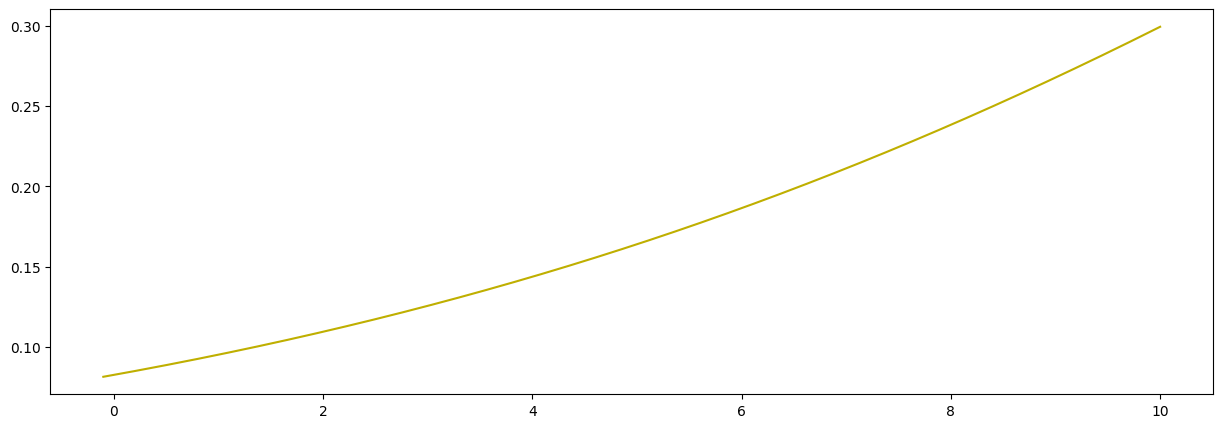

In [17]:
fig, ax = plt.subplots(figsize = (15, 5))

ax.plot(x_axis, probabilities, color=event_colours[event_type])
plt.show()

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

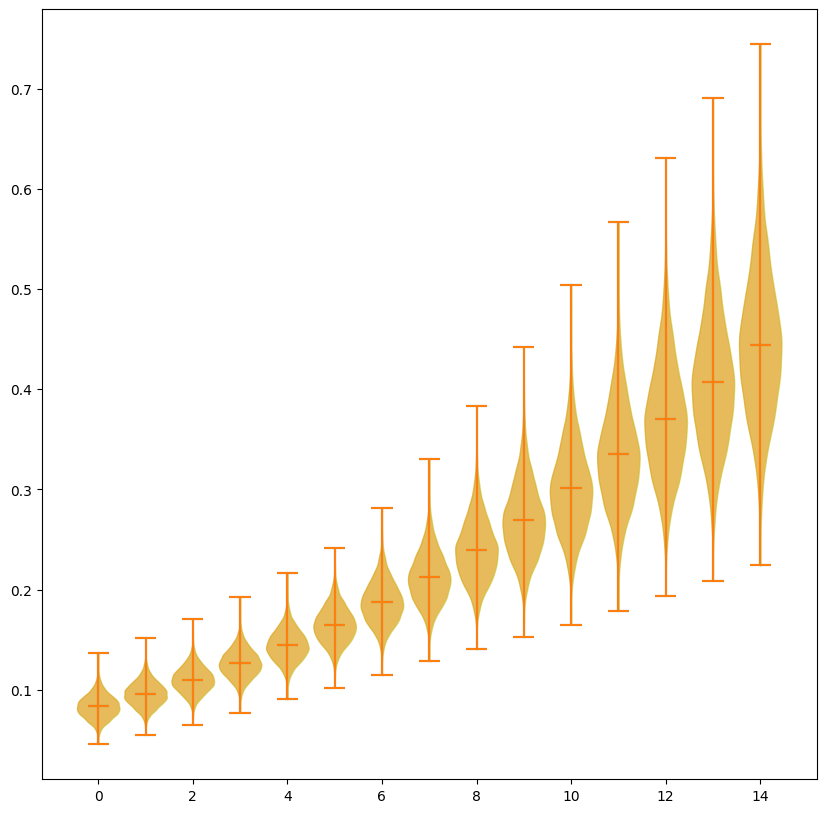

In [18]:
posterior_probability_plot(1, event_chain[['alpha', 'beta_']], event_range=15, box=False, color=event_colours[event_type])

In [19]:
np.quantile(event_chain['beta_'], 0.1)

0.12456029001653998

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!


Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000129 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!


Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!


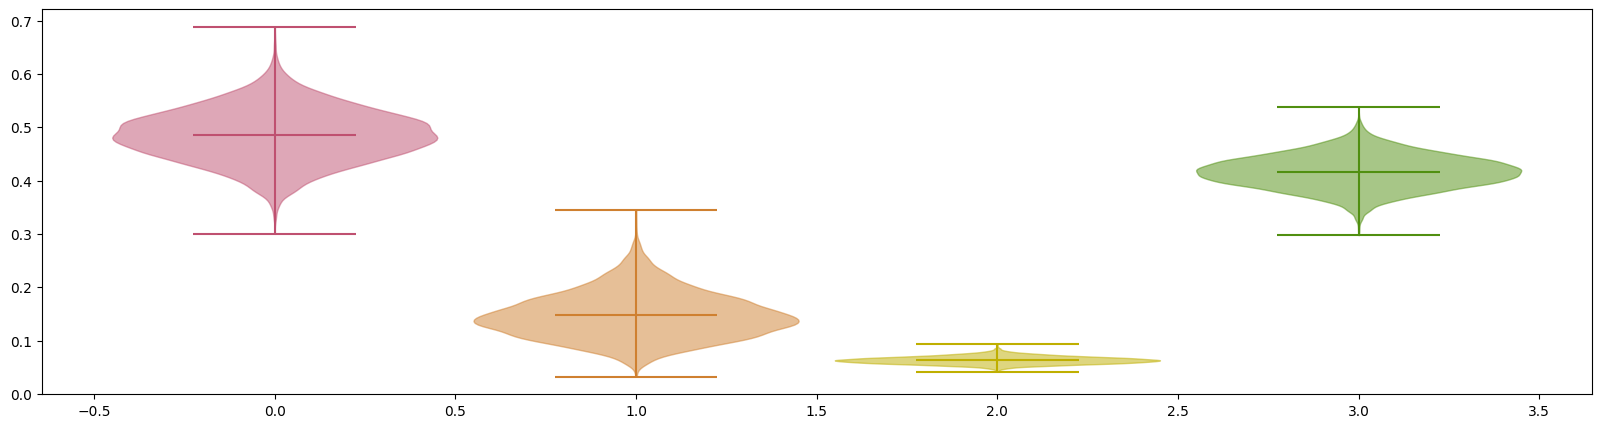

In [20]:
fig, ax = plt.subplots(figsize = (20, 5))

for idx, event in enumerate(['Battles', 'Explosions/Remote violence', 'Riots', 'Violence against civilians']):
    filter_dict = {'ADM2_name':'Dhaka', 'EVENT_TYPE':event}
    model, samples_null = model_sample(6, data, filter_dict, stan_filepath='stan_files/model6.stan')
    p_samples = samples_null['p'].values
    parts = ax.violinplot(p_samples, positions=[idx], widths=0.9, showmeans=True)
    colour = event_colours[event]
    for pc in parts['bodies']:
        pc.set_facecolor(colour)
        pc.set_edgecolor(colour)
        pc.set_alpha(0.5)
    for key in parts.keys():
        if key != 'bodies':
            parts[key].set_color(colour)

            

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/108000)
Sampling:   0% (2/108000)
Sampling:   0% (3/108000)
Sampling:  25% (27003/108000)
Sampling:  50% (54002/108000)
Sampling:  75% (81001/108000)
Sampling: 100% (108000/108000)
Sampling: 100% (108000/108000), done.
Messages received during sampling:
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
  Adjust your expectations accordingly!


Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/108000)
Sampling:  25% (27001/108000)
Sampling:  50% (54001/108000)
Sampling:  75% (81001/108000)
Sampling: 100% (108000/108000)
Sampling: 100% (108000/108000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!


Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/108000)
Sampling:   0% (2/108000)
Sampling:   0% (3/108000)
Sampling:   0% (4/108000)
Sampling:   2% (2004/108000)
Sampling:   4% (4004/108000)
Sampling:   6% (6004/108000)
Sampling:   7% (8004/108000)
Sampling:  31% (33003/108000)
Sampling:  54% (58002/108000)
Sampling:  77% (83001/108000)
Sampling: 100% (108000/108000)

RuntimeError: Exception during call to services function: `OSError(28, 'No space left on device')`, traceback: `['  File "/data/florican/jamiesonball/miniconda3/envs/stan_env/lib/python3.8/asyncio/tasks.py", line 280, in __step\n    result = coro.send(None)\n', '  File "/data/florican/jamiesonball/miniconda3/envs/stan_env/lib/python3.8/site-packages/httpstan/services_stub.py", line 158, in call\n    httpstan.cache.dump_fit(b"".join(compressed_parts), fit_name)\n', '  File "/data/florican/jamiesonball/miniconda3/envs/stan_env/lib/python3.8/site-packages/httpstan/cache.py", line 111, in dump_fit\n    fh.write(fit_bytes)\n']`

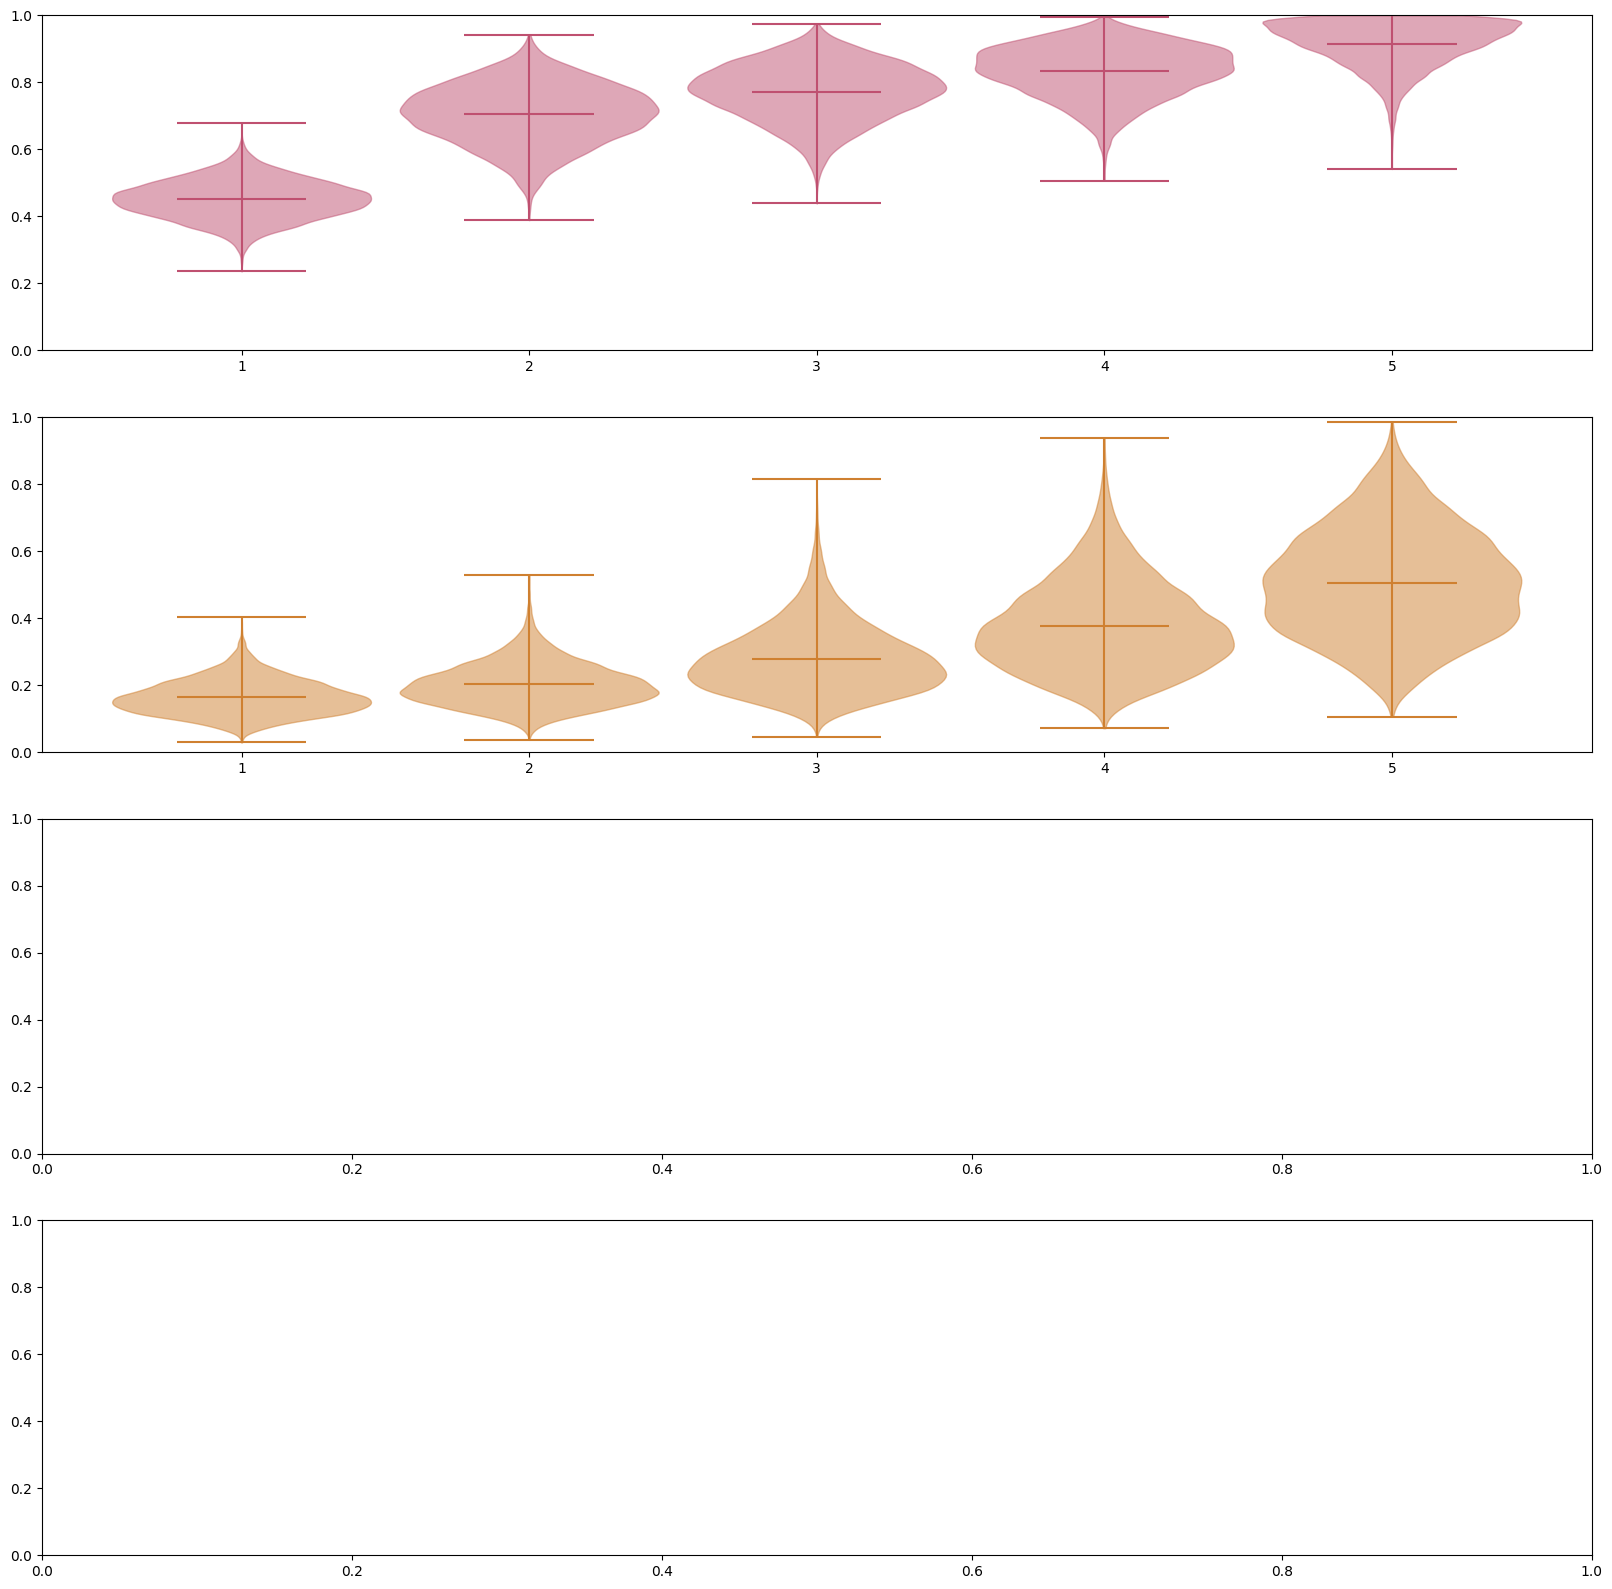

In [21]:
fig, ax = plt.subplots(4, figsize = (20, 20))

fatal_events = ['Battles', 'Explosions/Remote violence', 'Riots', 'Violence against civilians']

for idx, event in enumerate(fatal_events):
    filter_dict = {'ADM2_name':'Dhaka', 'EVENT_TYPE':event}
    model, samples_null = model_sample(4, data, filter_dict, stan_filepath='stan_files/model4.stan', max_bin=5)
    required_columns = [f'p.{i}' for i in range(1,5)]
    required_columns.append('pK')
    p_samples = samples_null[required_columns].values
    parts = ax[idx].violinplot(p_samples, positions=[i for i in range(1,6)], widths=0.9, showmeans=True)
    colour = event_colours[event]
    for pc in parts['bodies']:
        pc.set_facecolor(colour)
        pc.set_edgecolor(colour)
        pc.set_alpha(0.5)
    for key in parts.keys():
        if key != 'bodies':
            parts[key].set_color(colour)
    ax[idx].set(ylim=(0,1))

In [ ]:
from general_model import print_ess

Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000142 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000125 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9673.736882422181 for parameter alpha
Effective sample size of 9729.115234020586 for parameter beta_



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000144 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000153 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00011 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9772.838964485174 for parameter alpha
Effective sample size of 9754.908228839447 for parameter beta_



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 10084.6552402826 for parameter alpha
Effective sample size of 9796.79543928366 for parameter beta_



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 10110.377144475971 for parameter alpha
Effective sample size of 9902.878616852502 for parameter beta_



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9977.00230000121 for parameter pK
Effective sample size of 9919.971849025715 for parameter q.2
Effective sample size of 9923.39048514155 for parameter q.1



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 10081.268364805794 for parameter pK
Effective sample size of 9867.666334977233 for parameter q.2
Effective sample size of 9907.71889207173 for parameter q.1



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00015 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9221.037430403168 for parameter pK
Effective sample size of 9489.596585837891 for parameter q.2
Effective sample size of 9685.483186635758 for parameter q.1



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9676.088495448063 for parameter pK
Effective sample size of 9908.280020591003 for parameter q.2
Effective sample size of 9936.394495258346 for parameter q.1



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9734.463136242355 for parameter p



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9542.69097077562 for parameter p



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000129 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9494.50397438286 for parameter p



Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!




EFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT
Effective sample size of 9707.065797941492 for parameter p





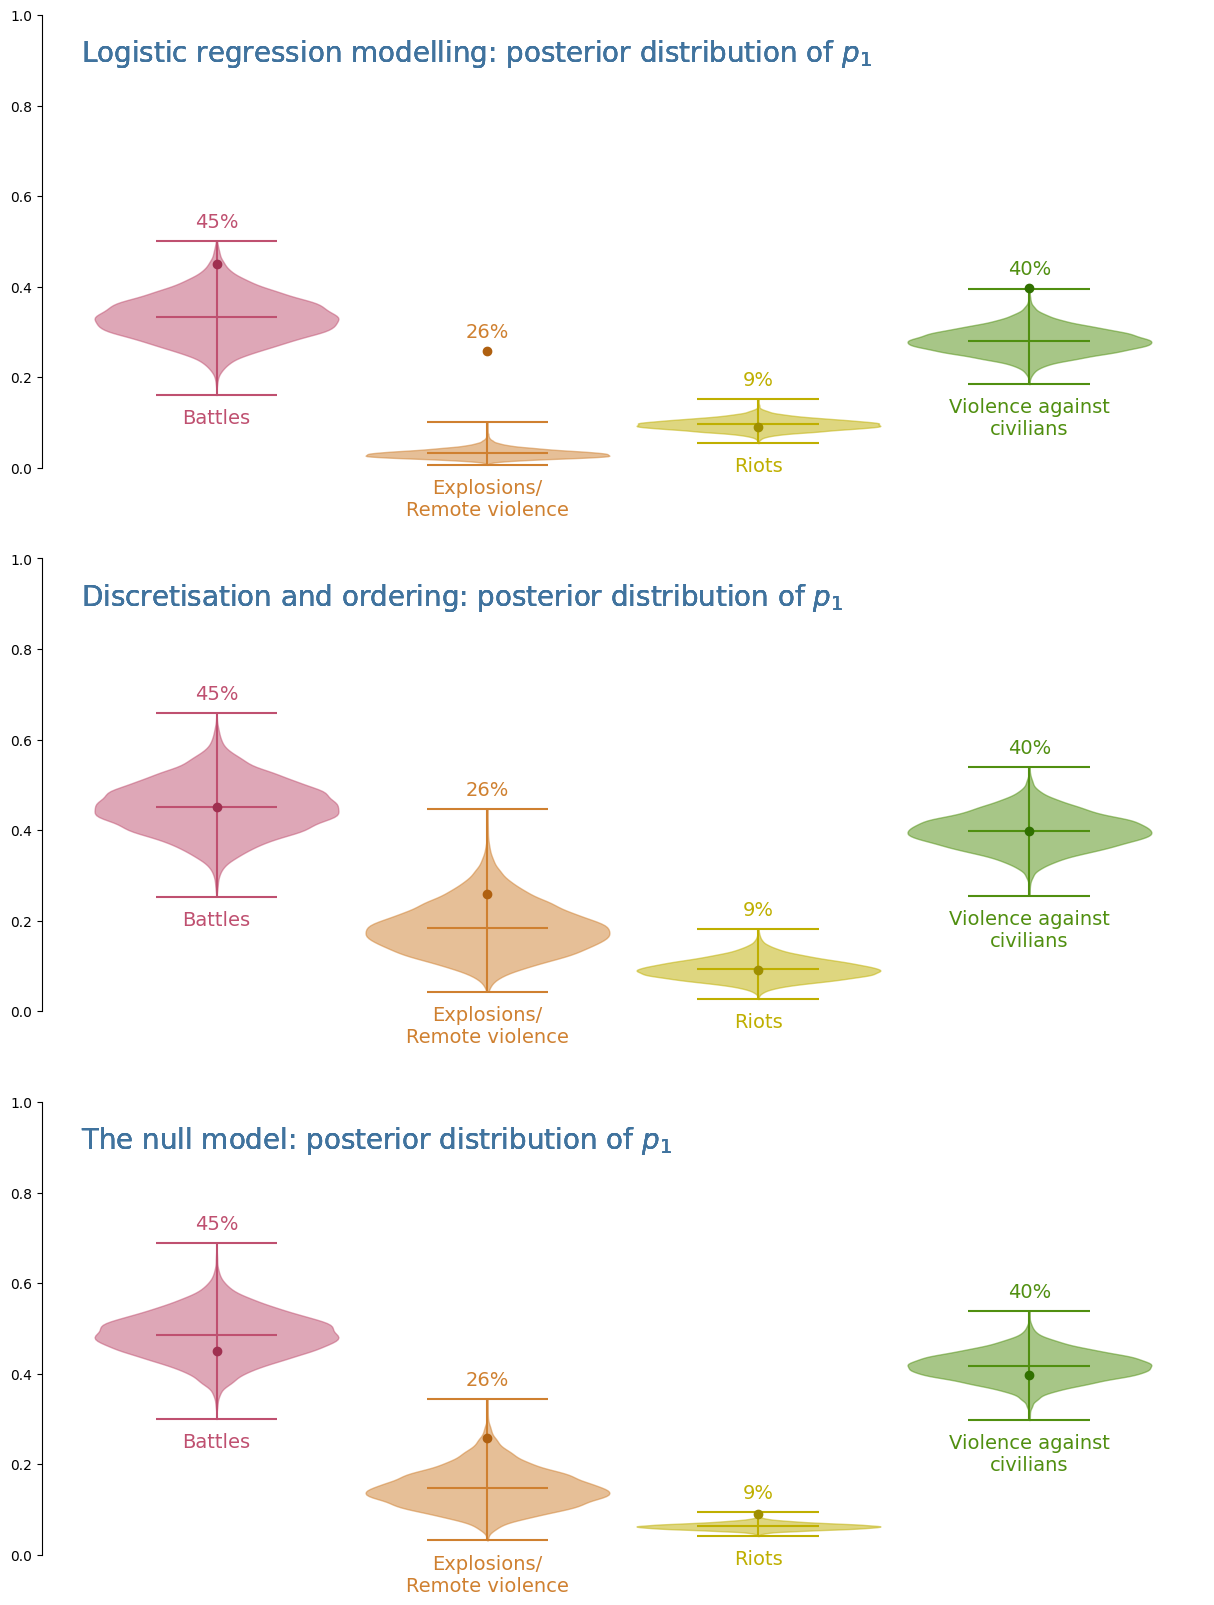

In [ ]:
fig, ax = plt.subplots(3, figsize=(15, 20))

xlabels = ['Battles', 'Explosions/\nRemote violence', 'Riots', 'Violence against\ncivilians']

titles = {1:'Logistic regression modelling',
          4:'Discretisation and ordering',
          6:'The null model'}

for graph_idx, model_num in enumerate([1, 4, 6]):
    stan_filepath = f'stan_files/model{model_num}.stan'
    for idx, event in enumerate(fatal_events):
        filter_dict = {'ADM2_name':'Dhaka', 'EVENT_TYPE':event}
        colour = event_colours[event]
        model, samples = model_sample(model_num, data, filter_dict, stan_filepath=stan_filepath, max_bin=3)
        if model_num == 1:
            print('\n\nEFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT')
            print_ess(samples[['alpha', 'beta_']], ['alpha', 'beta_'])
            print('\n\n')
            samples = samples[['alpha', 'beta_']].values
            probabilities = [single_logit(1, sample) for sample in samples]
            
        elif model_num == 4:
            print('\n\nEFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT')
            print_ess(samples[['pK', 'q.2', 'q.1']], ['pK', 'q.2', 'q.1'])
            print('\n\n')
            probabilities = samples['p.1'].values
        elif model_num == 6:
            print('\n\nEFFECTIVE SAMPLE SIZES FROM THE STAN OUTPUT')
            print(f'Effective sample size of {az.ess(samples["p"].values)} for parameter p')
            print('\n\n')
            probabilities = samples['p'].values
        parts = ax[graph_idx].violinplot(probabilities, positions=[idx], widths=0.9, showmeans=True)
        for pc in parts['bodies']:
            pc.set_facecolor(colour)
            pc.set_edgecolor(colour)
            pc.set_alpha(0.5)
        for key in parts.keys():
            if key != 'bodies':
                parts[key].set_color(colour)
        ax[graph_idx].set(ylim=(0,1),
                        #   xticks=[0,1,2,3],
                        #   xticklabels=xlabels
                          xticks=[]
                          )
        ax[graph_idx].text(idx, np.min(probabilities)-0.03, xlabels[idx], ha='center', va='top', c=colour, size=14)
        sub_frame = data.loc[data['ADM2_name'] == 'Dhaka'].loc[data['EVENT_TYPE'] == event].groupby('WEEK', as_index=False)[['FATALITIES', 'RAW_COUNTS']].sum()
        sub_frame = sub_frame.loc[sub_frame['RAW_COUNTS'] == 1]
        fatal = len(sub_frame.loc[sub_frame['FATALITIES'] > 0])
        total = len(sub_frame)
        ax[graph_idx].plot(idx, fatal/total, marker='o', c=tuple([max(col-0.125, 0) for col in colour]))
        ax[graph_idx].text(idx, max(np.max(probabilities), fatal/total)+0.03, f'{round(fatal/total * 100)}%', ha='center', c=colour, size=14)
        ax[graph_idx].text(-0.5, 0.95, rf'{titles[model_num]}: posterior distribution of $p_1$', size=20, ha='left', va='top', c=(64/255, 115/255, 158/255))
        ax[graph_idx].spines['top'].set_visible(False)
        ax[graph_idx].spines['right'].set_visible(False)
        ax[graph_idx].spines['bottom'].set_visible(False)
        ax[graph_idx].tick_params(bottom=False)

Sampling using Metropolis Hastings MCMC
Proposal acceptance rate of 0.3131 for parameter alpha
Proposal acceptance rate of 0.344 for parameter beta_


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 514.8466960258185 for parameter alpha
Effective sample size of 514.5712282822942 for parameter beta_
Sampling using Metropolis Hastings MCMC
Proposal acceptance rate of 0.423 for parameter alpha
Proposal acceptance rate of 0.3568 for parameter beta_


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 1900.543798832436 for parameter alpha
Effective sample size of 1750.486158946872 for parameter beta_
Sampling using Metropolis Hastings MCMC


/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:159: RuntimeWarning: divide by zero encountered in log
  lhoods = [resp*np.log(prob) + (1-resp)*np.log(1-prob) for prob, resp in zip(probabilities, responses)]
/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:159: RuntimeWarning: invalid value encountered in scalar multiply
  lhoods = [resp*np.log(prob) + (1-resp)*np.log(1-prob) for prob, resp in zip(probabilities, responses)]


Proposal acceptance rate of 0.2218 for parameter alpha
Proposal acceptance rate of 0.0358 for parameter beta_


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 501.6936329748854 for parameter alpha
Effective sample size of 199.41819295357018 for parameter beta_
Sampling using Metropolis Hastings MCMC
Proposal acceptance rate of 0.2312 for parameter alpha
Proposal acceptance rate of 0.2258 for parameter beta_


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 355.77259440620344 for parameter alpha
Effective sample size of 384.1098245808131 for parameter beta_
Sampling using Metropolis-Hastings MCMC


/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(x/(1-x))


Proposal acceptance rate of 0.3714 for parameter pK
Proposal acceptance rate of 0.9969 for parameter q.2
Proposal acceptance rate of 0.2165 for parameter q.1


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 825.1443207289125 for parameter pK
Effective sample size of 44.49805489141362 for parameter q.2
Effective sample size of 645.3939206524371 for parameter q.1



Sampling using Metropolis-Hastings MCMC


/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(x/(1-x))


Proposal acceptance rate of 0.2778 for parameter pK
Proposal acceptance rate of 0.9991 for parameter q.2
Proposal acceptance rate of 0.9982 for parameter q.1


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 1787.2577107749764 for parameter pK
Effective sample size of 71.680829198276 for parameter q.2
Effective sample size of 11.168000106704561 for parameter q.1



Sampling using Metropolis-Hastings MCMC


/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(x/(1-x))


Proposal acceptance rate of 0.1053 for parameter pK
Proposal acceptance rate of 0.9888 for parameter q.2
Proposal acceptance rate of 0.3035 for parameter q.1


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 343.6822521913219 for parameter pK
Effective sample size of 29.525080800019765 for parameter q.2
Effective sample size of 508.7418608480033 for parameter q.1



Sampling using Metropolis-Hastings MCMC


/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:205: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(x/(1-x))


Proposal acceptance rate of 0.1754 for parameter pK
Proposal acceptance rate of 0.9938 for parameter q.2
Proposal acceptance rate of 0.1803 for parameter q.1


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 421.44874253328265 for parameter pK
Effective sample size of 54.26568556676749 for parameter q.2
Effective sample size of 511.4997822375787 for parameter q.1



Sampling using Metropolis-Hastings MCMC
Proposal acceptance rate of 0.54 for parameter p


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 2141.5473141301536 for parameter p



Sampling using Metropolis-Hastings MCMC
Proposal acceptance rate of 0.7061 for parameter p


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 1181.0623466780658 for parameter p



Sampling using Metropolis-Hastings MCMC


/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:368: RuntimeWarning: divide by zero encountered in log
  log_lhoods = [fatal * np.log(prob) + (1-fatal) * np.log(1-prob) for prob, fatal in zip(probabilities, responses)]
/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:368: RuntimeWarning: invalid value encountered in scalar multiply
  log_lhoods = [fatal * np.log(prob) + (1-fatal) * np.log(1-prob) for prob, fatal in zip(probabilities, responses)]


Proposal acceptance rate of 0.3788 for parameter p


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 2294.2484132561594 for parameter p



Sampling using Metropolis-Hastings MCMC
Proposal acceptance rate of 0.4005 for parameter p


EFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT
Effective sample size of 2359.9856981962885 for parameter p





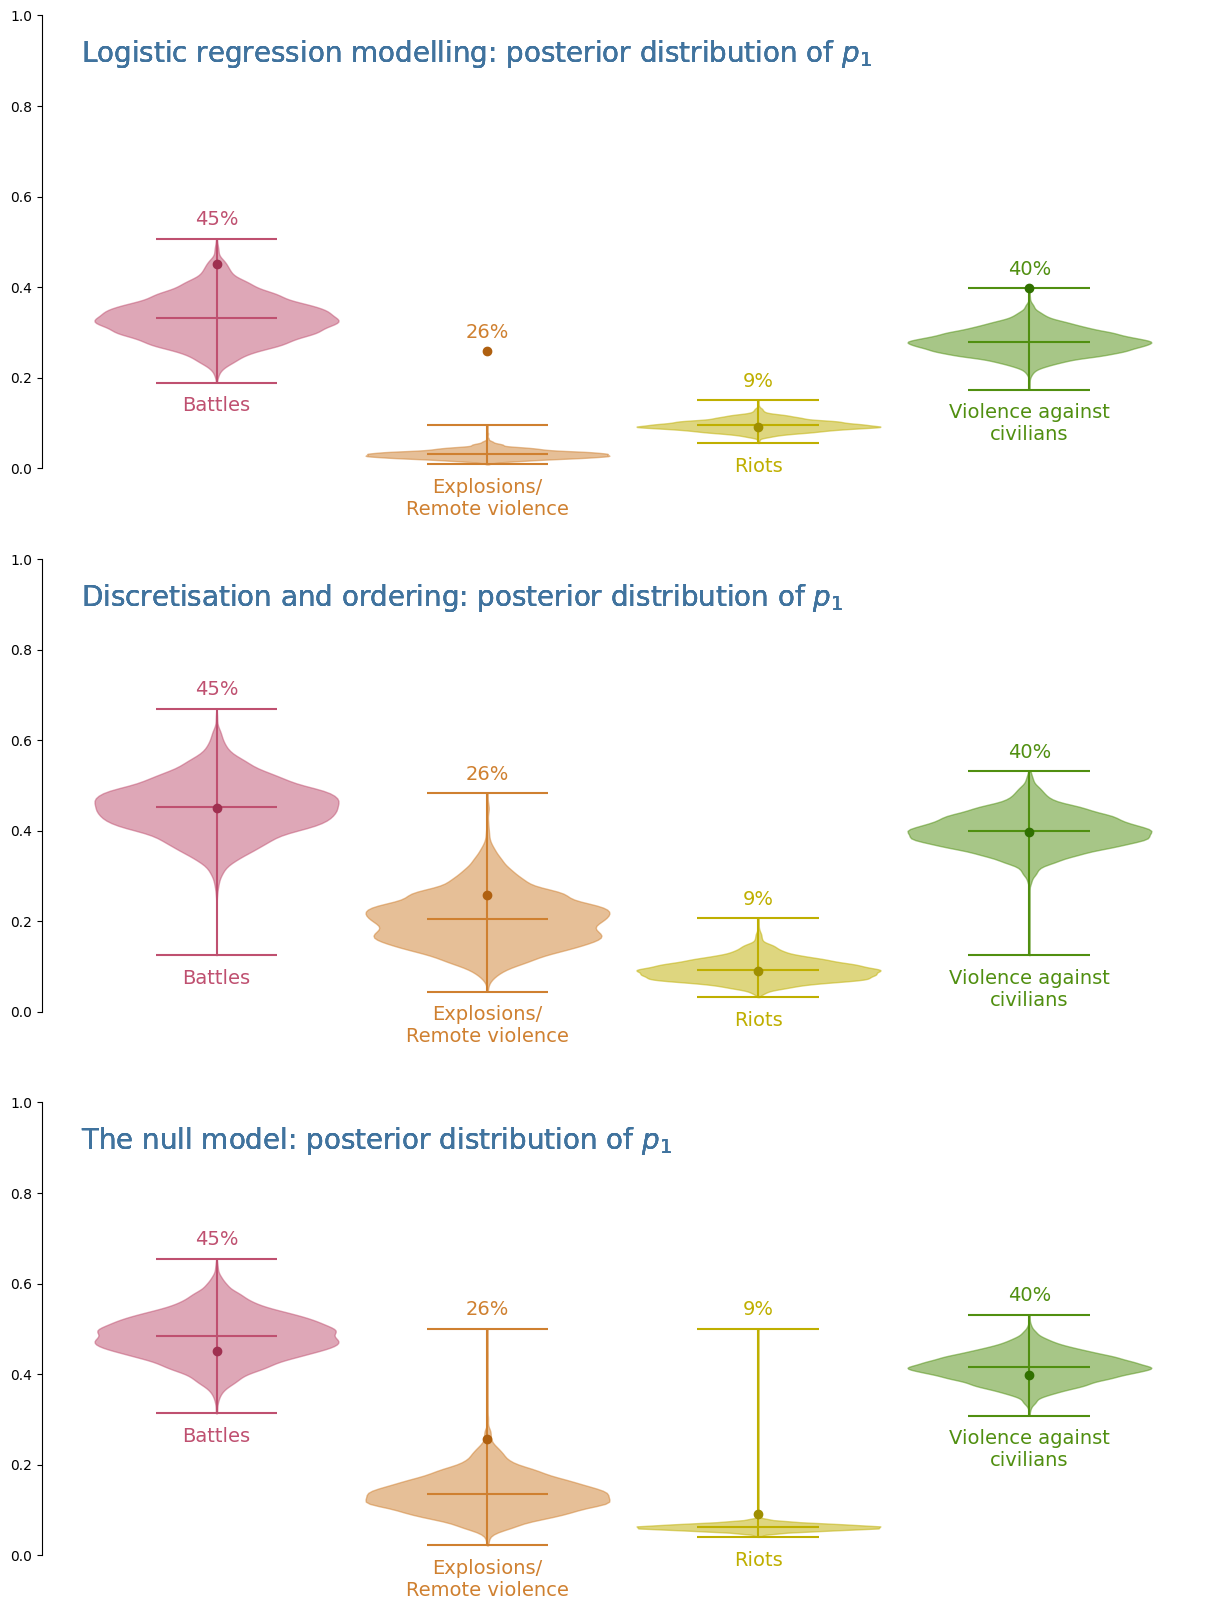

In [ ]:
fig, ax = plt.subplots(3, figsize=(15, 20))

xlabels = ['Battles', 'Explosions/\nRemote violence', 'Riots', 'Violence against\ncivilians']

titles = {1:'Logistic regression modelling',
          4:'Discretisation and ordering',
          6:'The null model'}

for graph_idx, model_num in enumerate([1, 4, 6]):
    for idx, event in enumerate(fatal_events):
        filter_dict = {'ADM2_name':'Dhaka', 'EVENT_TYPE':event}
        colour = event_colours[event]
        if model_num == 1:
            parameter_info = {'names':['alpha', 'beta_'], 'hyperparameters':[[0,1], [0,1]], 'stepsizes':[0.7, 0.7]}
            samples = model_sample(1, data, filter_dict, parameter_info=parameter_info)
            print('\n\nEFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT')
            print_ess(samples, ['alpha', 'beta_'])
            samples = samples[['alpha', 'beta_']].values
            probabilities = [single_logit(1, sample) for sample in samples]
        elif model_num == 4:
            parameter_info = {'names':['pK', 'q.2', 'q.1'], 'hyperparameters':[[1,1],[1,1],[1,1]], 'stepsizes':[0.2, 0.01, 0.2]}
            samples = model_sample(4, data, filter_dict, parameter_info=parameter_info, max_bin=3)
            print('\n\nEFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT')
            print_ess(samples[['pK', 'q.2', 'q.1']], ['pK', 'q.2', 'q.1'])
            print('\n\n')
            samples['p.1'] = samples['pK'] * samples['q.2'] * samples['q.1']
            probabilities = samples['p.1'].values
        elif model_num == 6:
            parameter_info = {'names':['p'], 'hyperparameters':[1,1], 'stepsizes':0.7}
            samples = model_sample(6, data, filter_dict, parameter_info=parameter_info)
            print('\n\nEFFECTIVE SAMPLE SIZES FROM THE MH MCMC OUTPUT')
            print(f'Effective sample size of {az.ess(samples["p"].values)} for parameter p')
            print('\n\n')
            probabilities = samples['p'].values
        parts = ax[graph_idx].violinplot(probabilities, positions=[idx], widths=0.9, showmeans=True)
        for pc in parts['bodies']:
            pc.set_facecolor(colour)
            pc.set_edgecolor(colour)
            pc.set_alpha(0.5)
        for key in parts.keys():
            if key != 'bodies':
                parts[key].set_color(colour)
        ax[graph_idx].set(ylim=(0,1),
                        #   xticks=[0,1,2,3],
                        #   xticklabels=xlabels
                          xticks=[]
                          )
        ax[graph_idx].text(idx, np.min(probabilities)-0.03, xlabels[idx], ha='center', va='top', c=colour, size=14)
        sub_frame = data.loc[data['ADM2_name'] == 'Dhaka'].loc[data['EVENT_TYPE'] == event].groupby('WEEK', as_index=False)[['FATALITIES', 'RAW_COUNTS']].sum()
        sub_frame = sub_frame.loc[sub_frame['RAW_COUNTS'] == 1]
        fatal = len(sub_frame.loc[sub_frame['FATALITIES'] > 0])
        total = len(sub_frame)
        ax[graph_idx].plot(idx, fatal/total, marker='o', c=tuple([max(col-0.125, 0) for col in colour]))
        ax[graph_idx].text(idx, max(np.max(probabilities), fatal/total)+0.03, f'{round(fatal/total * 100)}%', ha='center', c=colour, size=14)
        ax[graph_idx].text(-0.5, 0.95, rf'{titles[model_num]}: posterior distribution of $p_1$', size=20, ha='left', va='top', c=(64/255, 115/255, 158/255))
        ax[graph_idx].spines['top'].set_visible(False)
        ax[graph_idx].spines['right'].set_visible(False)
        ax[graph_idx].spines['bottom'].set_visible(False)
        ax[graph_idx].tick_params(bottom=False)

In [ ]:
samples

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p
draws,,,,,,,,
0,-140.869063,0.989022,1.064040,1.0,3.0,0.0,141.010328,0.424093
1,-143.890204,1.000000,0.821867,1.0,1.0,0.0,144.642166,0.494992
2,-140.919224,0.997996,1.122072,1.0,1.0,0.0,140.939825,0.404080
3,-142.728070,0.600048,1.233106,1.0,1.0,0.0,142.789176,0.478117
4,-141.082307,0.947262,1.064040,1.0,3.0,0.0,141.096956,0.394858
...,...,...,...,...,...,...,...,...
9995,-141.259085,0.891020,1.233106,1.0,3.0,0.0,141.304048,0.388106
9996,-140.943815,0.996049,1.064040,1.0,1.0,0.0,140.965557,0.430832
9997,-140.902596,0.997849,0.821867,1.0,1.0,0.0,140.908498,0.405452


In [ ]:
import geopandas as gpd

In [ ]:
shapefile_dir = os.path.join(project_dir, 'shapefiles')
shapefile_filepath_1 = os.path.join(shapefile_dir, 'gadm41_BGD_1.shp')
shapefile_filepath_2 = os.path.join(shapefile_dir, 'gadm41_BGD_2.shp')
map_df2 = gpd.read_file(shapefile_filepath_2)
map_df1 = gpd.read_file(shapefile_filepath_1)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def create_colormap(colour):
    return LinearSegmentedColormap.from_list('mycmap', ['white', colour])

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000108 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00012 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000134 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00011 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!


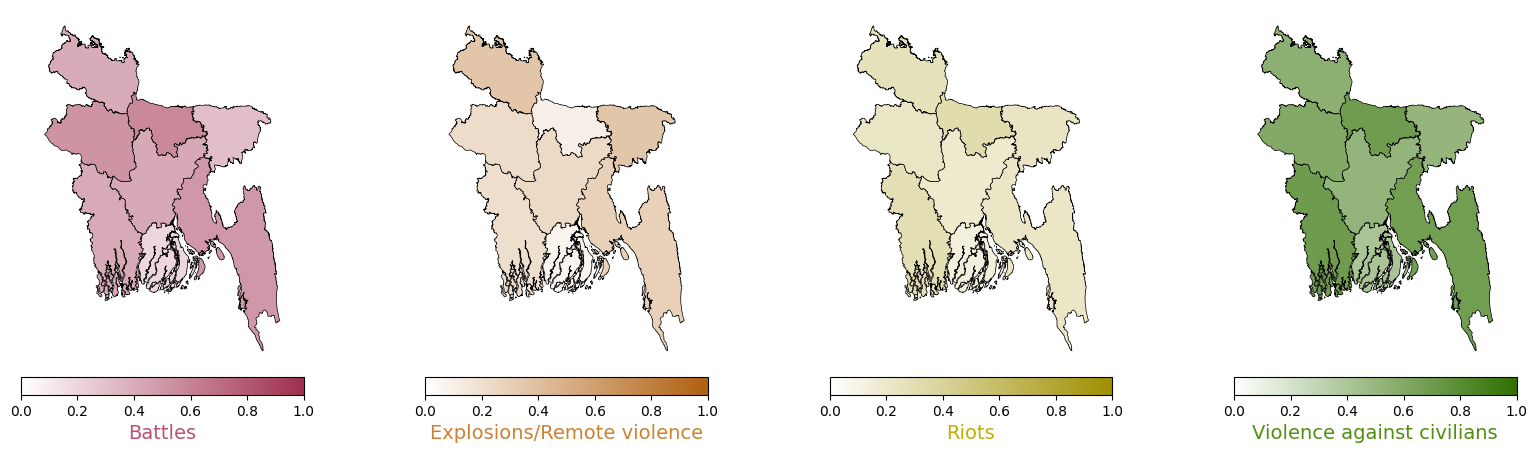

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for idx, event in enumerate(fatal_events):
    divisions = []
    p1_values = []
    for division in np.unique(data['ADMIN1'].values):
        filter_dict = {'ADMIN1':division,
                       'EVENT_TYPE':event}
        model, samples = model_sample(4, data, filter_dict, stan_filepath='stan_files/model4.stan', max_bin=3)
        p1_mean = np.mean(samples['p.1'].values)
        p1_values.append(p1_mean)
        divisions.append(division)
    colour = event_colours[event]
    colour = tuple([max(col-0.125, 0) for col in colour])
    probability_data = pd.DataFrame(list(zip(divisions, p1_values)), columns=['ADMIN1', 'P1'])
    merged_df = map_df1.merge(probability_data, left_on = 'NAME_1', right_on = 'ADMIN1', how = 'left')
    ax[idx] = merged_df.plot(column='P1', cmap = create_colormap(colour), linewidth = 0.5, ax = ax[idx], edgecolor = '0.0', legend = False, vmin=0, vmax=1)

    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=create_colormap(colour), norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(fr'{event}', c=event_colours[event], size=14)

    ax[idx].set(yticks=[], xticks=[])
    ax[idx].axis('off')

plt.show()

Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000254 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000144 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000111 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00019 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.9 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000154 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000225 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000125 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.25 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 0.000191 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.91 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.0001 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00011 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!


Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000128 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!


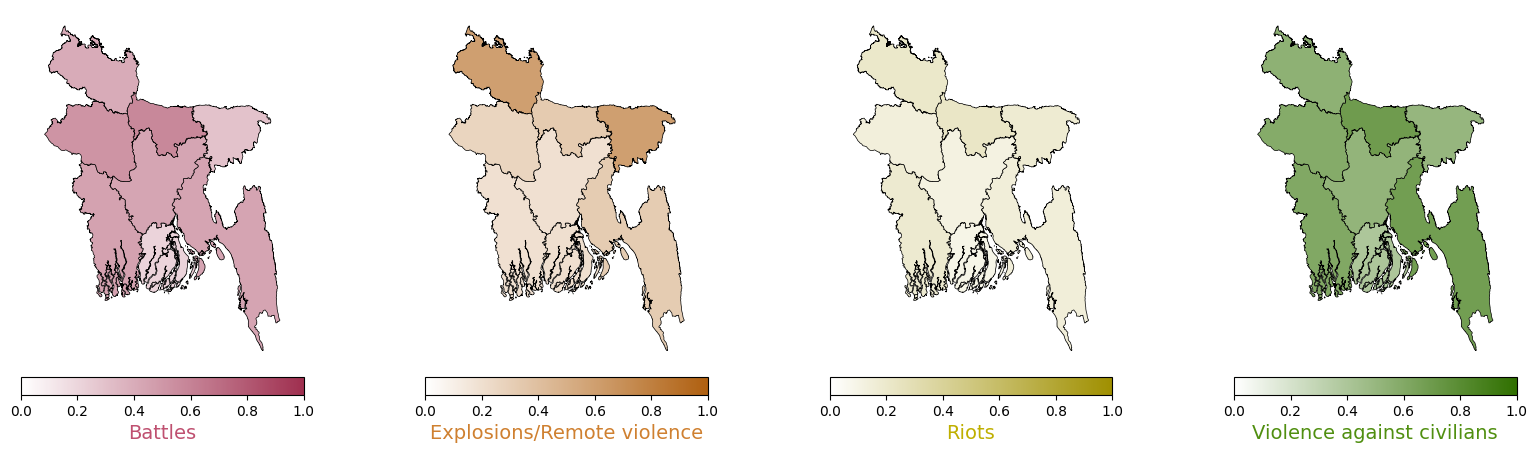

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for idx, event in enumerate(fatal_events):
    divisions = []
    p1_values = []
    for division in np.unique(data['ADMIN1'].values):
        filter_dict = {'ADMIN1':division,
                       'EVENT_TYPE':event}
        model, samples = model_sample(6, data, filter_dict, stan_filepath='stan_files/model6.stan')
        p1_mean = np.mean(samples['p'].values)
        p1_values.append(p1_mean)
        divisions.append(division)
    colour = event_colours[event]
    colour = tuple([max(col-0.125, 0) for col in colour])
    probability_data = pd.DataFrame(list(zip(divisions, p1_values)), columns=['ADMIN1', 'P1'])
    merged_df = map_df1.merge(probability_data, left_on = 'NAME_1', right_on = 'ADMIN1', how = 'left')
    ax[idx] = merged_df.plot(column='P1', cmap = create_colormap(colour), linewidth = 0.5, ax = ax[idx], edgecolor = '0.0', legend = False, vmin=0, vmax=1)

    divider = make_axes_locatable(ax[idx])
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=create_colormap(colour), norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(fr'{event}', c=event_colours[event], size=14)

    ax[idx].set(yticks=[], xticks=[])
    ax[idx].axis('off')

plt.show()

In [23]:
from hypothesis_testing import nr4_marginal_likelihood

from mcmc_functions import logit_ll, mod6_llh, mod4_llh

from general_model import model_observations

In [24]:
mod1_marg_liks = []

for event in fatal_events:
    filter_dict = {'ADM2_name':'Dhaka',
                   'EVENT_TYPE':event}
    responses, observations = model_observations(1, data, filter_dict, ignore_zero=False)
    samples = model_sample(1, data, filter_dict, stan_filepath='stan_files/model1.stan')[1][['alpha', 'beta_']].values
    marg_lik = nr4_marginal_likelihood(samples, logit_ll, responses, observations, convergence_diagnostic=True)
    mod1_marg_liks.append(marg_lik)

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000142 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000125 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!


Estimate in iteration 2 of -80.15647125336352
Estimate in iteration 3 of -79.4162506599538
Estimate in iteration 4 of -79.12369123760014
Estimate in iteration 5 of -79.00418623666091
Estimate in iteration 6 of -78.95475302322102
Estimate in iteration 7 of -78.93420237130513
Estimate in iteration 8 of -78.92564145965811
Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000144 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000153 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00011 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.
  Adjust your expectations accordingly!


Estimate in iteration 2 of -46.5005263549559
Estimate in iteration 3 of -45.79220635629218
Estimate in iteration 4 of -45.55474532838901
Estimate in iteration 5 of -45.47465942763604
Estimate in iteration 6 of -45.447612768206284
Estimate in iteration 7 of -45.43847503936946
Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!


Estimate in iteration 2 of -108.99961934066056
Estimate in iteration 3 of -113.49942901099084
Estimate in iteration 4 of -117.99923868132112
Estimate in iteration 5 of -122.4990483516514
Estimate in iteration 6 of -126.99885802198168
Estimate in iteration 7 of -131.49866769231193
Estimate in iteration 8 of -135.99847736264218
Estimate in iteration 9 of -140.49828703297243
Estimate in iteration 10 of -144.99809670330268
Estimate in iteration 11 of -149.49790637363293
Estimate in iteration 12 of -153.99771604396318
Estimate in iteration 13 of -158.49752571429343
Estimate in iteration 14 of -162.99733538462368
Estimate in iteration 15 of -167.49714505495393
Estimate in iteration 16 of -171.99695472528418
Estimate in iteration 17 of -176.49676439561443
Estimate in iteration 18 of -180.99657406594469
Estimate in iteration 19 of -185.49638373627465
Estimate in iteration 20 of -189.9961934065807
Estimate in iteration 21 of -194.49600307473182
Estimate in iteration 22 of -198.9958125489425
Est


Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!


Estimate in iteration 2 of -108.99961934066056
Estimate in iteration 3 of -113.49942901099084
Estimate in iteration 4 of -117.99923868132112
Estimate in iteration 5 of -122.4990483516514
Estimate in iteration 6 of -126.99885802198168
Estimate in iteration 7 of -131.49866769231193
Estimate in iteration 8 of -135.9984773626418
Estimate in iteration 9 of -140.49828703293966
Estimate in iteration 10 of -144.9980967003531
Estimate in iteration 11 of -149.49790610816981
Estimate in iteration 12 of -153.99769215259394
Estimate in iteration 13 of -158.4953780308284
Estimate in iteration 14 of -162.82214904260022
Estimate in iteration 15 of -164.95032166380668
Estimate in iteration 16 of -165.61363309038052
Estimate in iteration 17 of -165.828790047912
Estimate in iteration 18 of -165.89845802433942
Estimate in iteration 19 of -165.92097205842853
Estimate in iteration 20 of -165.92824208416883


In [25]:
mod1_marg_liks

[-78.92564145965811,
 -45.43847503936946,
 -215.1395658274149,
 -165.92824208416883]

In [28]:
mod4_marg_liks = []

for event in fatal_events:
    filter_dict = {'ADM2_name':'Dhaka',
                   'EVENT_TYPE':event}
    responses, observations = model_observations(4, data, filter_dict, max_bin=3)
    samples = model_sample(4, data, filter_dict, stan_filepath='stan_files/model4.stan', max_bin=3)[1][['pK', 'p.2', 'p.1']].values
    marg_lik = nr4_marginal_likelihood(samples, mod4_llh, responses, observations, convergence_diagnostic=True)
    mod4_marg_liks.append(marg_lik)

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/108000)
Sampling:   0% (2/108000)
Sampling:  25% (27002/108000)
Sampling:  50% (54002/108000)
Sampling:  75% (81001/108000)
Sampling: 100% (108000/108000)
Sampling: 100% (108000/108000), done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!


Estimate in iteration 2 of -88.557253874117
Estimate in iteration 3 of -84.4332199381022
Estimate in iteration 4 of -81.36408713790341
Estimate in iteration 5 of -78.99240208145932
Estimate in iteration 6 of -77.10782419111446
Estimate in iteration 7 of -75.59940555855576
Estimate in iteration 8 of -74.38534110199443
Estimate in iteration 9 of -73.40742406414991
Estimate in iteration 10 of -72.61898070393184
Estimate in iteration 11 of -71.98302079943107
Estimate in iteration 12 of -71.4705419354988
Estimate in iteration 13 of -71.05841297121479
Estimate in iteration 14 of -70.72786198806747
Estimate in iteration 15 of -70.4634760376644
Estimate in iteration 16 of -70.25255460479713
Estimate in iteration 17 of -70.08465962819284
Estimate in iteration 18 of -69.95126010638973
Estimate in iteration 19 of -69.84542676338538
Estimate in iteration 20 of -69.76156335523235
Estimate in iteration 21 of -69.69517204166772
Estimate in iteration 22 of -69.64265201002212
Estimate in iteration 23 o


Building: found in cache, done.Sampling:   0%
Sampling:  25% (27000/108000)
Sampling:  50% (54000/108000)
Sampling:  75% (81000/108000)
Sampling: 100% (108000/108000)
Sampling: 100% (108000/108000), done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


Estimate in iteration 2 of -60.0164630394469
Estimate in iteration 3 of -56.203731322883144
Estimate in iteration 4 of -53.514956774113976
Estimate in iteration 5 of -51.5276585520063
Estimate in iteration 6 of -50.06002490104492
Estimate in iteration 7 of -48.96338291491294
Estimate in iteration 8 of -48.133907375169784
Estimate in iteration 9 of -47.501147126915896
Estimate in iteration 10 of -47.01524711461231
Estimate in iteration 11 of -46.64021383756963
Estimate in iteration 12 of -46.349769479512084
Estimate in iteration 13 of -46.12439556394536
Estimate in iteration 14 of -45.94933686452576
Estimate in iteration 15 of -45.81329599078373
Estimate in iteration 16 of -45.70755650863621
Estimate in iteration 17 of -45.62536528927764
Estimate in iteration 18 of -45.5614792978169
Estimate in iteration 19 of -45.5118239173695
Estimate in iteration 20 of -45.47323128992562
Estimate in iteration 21 of -45.44323824463284
Estimate in iteration 22 of -45.41992957908371
Estimate in iteratio


Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/108000)
Sampling:   0% (2/108000)
Sampling:   0% (3/108000)
Sampling:   0% (4/108000)
Sampling:  25% (27003/108000)
Sampling:  50% (54002/108000)
Sampling:  75% (81001/108000)
Sampling: 100% (108000/108000)
Sampling: 100% (108000/108000), done.
Messages received during sampling:
  Gradient evaluation took 0.000152 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000127 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000116 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
  Adjust your expectations acco

Estimate in iteration 2 of -108.99961934066056
Estimate in iteration 3 of -113.49942901099084
Estimate in iteration 4 of -117.99923868132112
Estimate in iteration 5 of -122.4990483516514
Estimate in iteration 6 of -126.99885802198168
Estimate in iteration 7 of -131.49866769231193
Estimate in iteration 8 of -135.99847736264218
Estimate in iteration 9 of -140.49828703297243
Estimate in iteration 10 of -144.99809670330268
Estimate in iteration 11 of -149.49790637363293
Estimate in iteration 12 of -153.99771604396318
Estimate in iteration 13 of -158.49752571429343
Estimate in iteration 14 of -162.99733538462368
Estimate in iteration 15 of -167.49714505495393
Estimate in iteration 16 of -171.99695472528418
Estimate in iteration 17 of -176.49676439561443
Estimate in iteration 18 of -180.99657406594463
Estimate in iteration 19 of -185.49638373627124
Estimate in iteration 20 of -189.9961934062717
Estimate in iteration 21 of -194.49600304691972
Estimate in iteration 22 of -198.9958100471336
Est


Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/108000)
Sampling:   0% (2/108000)
Sampling:   0% (3/108000)
Sampling:   0% (4/108000)
Sampling:  25% (27003/108000)
Sampling:  50% (54002/108000)
Sampling:  75% (81001/108000)
Sampling: 100% (108000/108000)
Sampling: 100% (108000/108000), done.
Messages received during sampling:
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordi

Estimate in iteration 2 of -108.99961934066056
Estimate in iteration 3 of -113.4994290109908
Estimate in iteration 4 of -117.99923868131796
Estimate in iteration 5 of -122.49904835136839
Estimate in iteration 6 of -126.99885799651169
Estimate in iteration 7 of -131.49866540003646
Estimate in iteration 8 of -135.99827123169436
Estimate in iteration 9 of -140.4809568011565
Estimate in iteration 10 of -144.55352277297726
Estimate in iteration 11 of -147.70934164914516
Estimate in iteration 12 of -150.18933410168898
Estimate in iteration 13 of -152.1883996183497
Estimate in iteration 14 of -153.81550249142572
Estimate in iteration 15 of -155.15247613331954
Estimate in iteration 16 of -156.2587572098622
Estimate in iteration 17 of -157.17738083875713
Estimate in iteration 18 of -157.94141333886853
Estimate in iteration 19 of -158.57645729659507
Estimate in iteration 20 of -159.1030876954078
Estimate in iteration 21 of -159.5387421325161
Estimate in iteration 22 of -159.89847194453068
Estima

In [29]:
mod4_marg_liks

[-69.47499283452002,
 -45.36830419573537,
 -232.1835836965165,
 -161.54818394399607]

In [34]:
mod7_marg_liks = []

for event in fatal_events:
    filter_dict = {'ADM2_name':'Dhaka',
                   'EVENT_TYPE':event}
    responses, observations = model_observations(1, data, filter_dict, ignore_zero=True)
    samples = model_sample(7, data, filter_dict)['p.1'].values
    marg_lik = nr4_marginal_likelihood(samples, mod6_llh, responses, observations, convergence_diagnostic=True)
    mod7_marg_liks.append(marg_lik)

Sampling directly from the Beta distribution, returning data frame
Estimate in iteration 2 of -62.08929403359144
Estimate in iteration 3 of -61.19977097775015
Estimate in iteration 4 of -60.92132512574278
Estimate in iteration 5 of -60.83650617200584
Estimate in iteration 6 of -60.81093616270597
Estimate in iteration 7 of -60.80325354194429
Sampling directly from the Beta distribution, returning data frame
Estimate in iteration 2 of -39.9402753004625
Estimate in iteration 3 of -37.767758787936344
Estimate in iteration 4 of -36.28758212747526
Estimate in iteration 5 of -35.263043586358464
Estimate in iteration 6 of -34.55779734934832
Estimate in iteration 7 of -34.07524952096684
Estimate in iteration 8 of -33.74647931979949
Estimate in iteration 9 of -33.523085651178945
Estimate in iteration 10 of -33.371553029987865
Estimate in iteration 11 of -33.26887885608475
Estimate in iteration 12 of -33.19936018027483
Estimate in iteration 13 of -33.1523130061837
Estimate in iteration 14 of -33.

In [31]:
mod7_marg_liks

[-60.80325354194429,
 -33.074548246252164,
 -213.26067481752455,
 -140.8047630097962]

In [36]:
mod6_marg_liks = []

for event in fatal_events:
    filter_dict = {'ADM2_name':'Dhaka',
                   'EVENT_TYPE':event}
    responses, observations = model_observations(1, data, filter_dict)
    samples = model_sample(6, data, filter_dict, stan_filepath='stan_files/model6.stan')[1]['p'].values
    marg_lik = nr4_marginal_likelihood(samples, mod6_llh, responses, observations, convergence_diagnostic=True)
    mod6_marg_liks.append(marg_lik)

Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:371: RuntimeWarning: divide by zero encountered in log
  log_lhoods = [fatal * np.log(prob) + (1-fatal) * np.log(1-prob) for prob, fatal in zip(probabilities, responses)]

Estimate in iteration 2 of -60.153090920396465
Estimate in iteration 3 of -60.071640948664005
Estimate in iteration 4 of -60.061682563525245
Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:371: RuntimeWarning: divide by zero encountered in log
  log_lhoods = [fatal * np.log(prob) + (1-fatal) * np.log(1-prob) for prob, fatal in zip(probabilities, responses)]

Estimate in iteration 2 of -26.32631108109861
Estimate in iteration 3 of -26.26994355197654
Estimate in iteration 4 of -26.26290045007757
Sampling using Stan, returning (stan.fit.Fit, data frame)
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000197 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000129 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:371: RuntimeWarn

Estimate in iteration 2 of -108.99961934066056
Estimate in iteration 3 of -113.49942901099084
Estimate in iteration 4 of -117.99923868132112
Estimate in iteration 5 of -122.4990483516514
Estimate in iteration 6 of -126.99885802198168
Estimate in iteration 7 of -131.49866769231193
Estimate in iteration 8 of -135.99847736264218
Estimate in iteration 9 of -140.49828703297243
Estimate in iteration 10 of -144.99809670330268
Estimate in iteration 11 of -149.49790637363293
Estimate in iteration 12 of -153.99771604396318
Estimate in iteration 13 of -158.4975257142934
Estimate in iteration 14 of -162.99733538462073
Estimate in iteration 15 of -167.49714505468688
Estimate in iteration 16 of -171.9969547012467
Estimate in iteration 17 of -176.4967622322398
Estimate in iteration 18 of -180.99637938147472
Estimate in iteration 19 of -185.47901623009764
Estimate in iteration 20 of -189.06136304285624
Estimate in iteration 21 of -189.7748066427219
Estimate in iteration 22 of -189.8634221879513
Estima


Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!
/data/florican/jamiesonball/Intern_Project/src/mcmc_functions.py:371: RuntimeWarning: divide by zero encountered in log
  log_lhoods = [fatal * np.log(prob) + (1-fatal) * np.log(1-prob) for prob, fatal in zip(probabilities, respon

Estimate in iteration 2 of -108.9996193406605
Estimate in iteration 3 of -113.49942901098647
Estimate in iteration 4 of -117.99923868093025
Estimate in iteration 5 of -122.49904831647618
Estimate in iteration 6 of -126.99885485622059
Estimate in iteration 7 of -131.49838281502468
Estimate in iteration 8 of -135.97316650042097
Estimate in iteration 9 of -139.32076302429817
Estimate in iteration 10 of -139.91194351969577
Estimate in iteration 11 of -139.98486406225004
Estimate in iteration 12 of -139.99369250218544


In [37]:
mod6_marg_liks

[-60.061682563525245,
 -26.26290045007757,
 -189.87550046189764,
 -139.99369250218544]

In [38]:
marg_lik_table = pd.DataFrame({'Event type':fatal_events,
                               'Logistic Regression':mod1_marg_liks,
                               'Dicretisation':mod4_marg_liks,
                               'Null model':mod7_marg_liks,
                               'Intuitive model':mod6_marg_liks})

In [39]:
marg_lik_table

,Event type,Logistic Regression,Dicretisation,Null model,Intuitive model
0,Battles,-78.925641,-69.474993,-60.803254,-60.061683
1,Explosions/Remote violence,-45.438475,-45.368304,-33.074548,-26.262900
2,Riots,-215.139566,-232.183584,-213.260675,-189.875500
3,Violence against civilians,-165.928242,-161.548184,-140.804763,-139.993693
